# Imports

In [1]:
%%capture --no-display
!pip install split-folders

In [2]:
import plotly.graph_objects as go
import shutil
from sklearn.svm import SVC
from PIL import Image
import warnings
from sklearn.metrics import confusion_matrix
warnings.filterwarnings("ignore")
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Sequential
from keras import models
import plotly.express as px
import numpy as np
import keras
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras import layers
import os
import seaborn as sns
from collections import Counter
from keras import backend as K
plt.style.use("ggplot")
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import glob
from pathlib import Path
import cv2
from sklearn.metrics import accuracy_score, classification_report
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from keras.applications import VGG16, InceptionV3
from keras.applications.resnet50 import ResNet50
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import glob
import splitfolders
import tensorflow_addons as tfa
from sklearn.ensemble import RandomForestClassifier
from pathlib import Path
from tensorflow.keras.applications.xception import Xception
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50, preprocess_input
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found. Make sure to enable GPU acceleration in the Colab notebook settings.')
else:
    print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Functions

In [4]:
def max_dim(images):
    max_width = 0
    max_height = 0
    for i in images:
        if len(i.shape) == 2:
            width, height = i.shape
        else:
            width, height, _ = i.shape
        max_width = max(max_width, width )
        max_height = max(max_height, height)
    return max_width, max_height

In [5]:
def augment_images(images, number_of_copies, augmentation_params): 
    
    reshaped_images = ([image.reshape((1,) + image.shape) for image in images])
    image_datagen = ImageDataGenerator(**augmentation_params)
    
    augmented_list = [
        next(image_datagen.flow(img, batch_size=1))[0]
        for img in reshaped_images
        for _ in range(number_of_copies)  
    ]
    return augmented_list

In [6]:
def evaluation(model, x_test, y_test):
    print(f"Evaluation {model.evaluate(x_test,y_test)}")
    y_pred = model.predict(x_test)
    y_pred = [i.argmax() for i in y_pred]
    print(f"Classification Report\n\n{classification_report(y_test,y_pred)}")

In [7]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    ax[0].plot(epochs, acc, 'ro', label='Training acc')
    ax[0].plot(epochs, val_acc, 'b', label='Validation acc')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()

    ax[1].plot(epochs, loss, 'ro', label='Training loss')
    ax[1].plot(epochs, val_loss, 'b', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()

In [8]:
def conf_matrix(model, test, labels, s = "dl", y_test = None):
    if s.lower() == "dl":
        y_test = test.classes
        y_pred = model.predict(test)
        y_pred = [i.argmax() for i in y_pred]
    else:
        y_pred = model.predict(test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels = labels,
                yticklabels= labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    return classification_report(y_test, y_pred)

In [9]:
def save_numpy_array_as_image(numpy_array, image_path):
    if numpy_array.dtype != 'uint8':
        numpy_array *= 255.0
        numpy_array = numpy_array.astype('uint8')
    
    image = Image.fromarray(numpy_array)
    image.save(image_path)

In [10]:
def extract_features(imgs):
    feature_extracted = []
    
    for img in imgs:
        expanded_img_array = np.expand_dims(img, axis=0)
        feature_extracted.append(model.predict(expanded_img_array).flatten())
        
    return feature_extracted

In [11]:
def plt_imshow(image, axis = False):
    plt.imshow(image)
    if axis == False: 
        plt.axis("off");
    plt.show

In [12]:
def load_and_process_images(folder_path, target_width, target_heigth): 
    read_images = [plt.imread(folder_path+'/'+i) for i in os.listdir(folder_path)]
    process_images = np.array([cv2.cvtColor(cv2.resize(i,(target_width, target_heigth)),cv2.COLOR_BGR2RGB) for i in read_images])
    return process_images

# EDA

In [13]:
width, height = 128, 128
path = "/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign"
benign_images = load_and_process_images(path, width, height)
path = "/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant"
malignant_images = load_and_process_images(path, width, height)
path = "/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal"
normal_images = load_and_process_images(path, width, height)

In [14]:
print(f"Number of images in benign class: {len(benign_images)}\
\nNumber of images in malignant class: {len(malignant_images)}\
\nNumber of images in normal class: {len(normal_images)}")

Number of images in benign class: 891
Number of images in malignant class: 421
Number of images in normal class: 266


In [15]:
labels = ['benign','normal','malignant']
values = [len(benign_images), len(normal_images), len(malignant_images)]

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_layout(title_text='Classes Distribution')
fig.show()

Classes are imbalanced, the images have different sizes, and some are either GRAY or RGB<br>
that will be solved in the preprocessing part

# PreProcessing

In [16]:
splitfolders.ratio('/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT', output="output", seed=1337, ratio=(0.7, 0.15,0.15)) 

Copying files: 1578 files [00:03, 419.84 files/s]


In [17]:
augmentation_params = {'horizontal_flip': True, 
                       'rotation_range': 30, 
                       'brightness_range': [0.8, 1.2], 
                       'zoom_range': 0.2}
#benign_images = augment_images(benign_images, 5, {})
malignant_images = augment_images(malignant_images, 3, augmentation_params)
normal_images = augment_images(normal_images, 4, augmentation_params)

In [18]:
labels = ['benign','normal','malignant']
values = [len(benign_images), len(normal_images), len(malignant_images)]

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_layout(title_text='Classes Distribution')
fig.show()

In [19]:
shutil.rmtree("/kaggle/working/output/train")

In [20]:
Path('/kaggle/working/output/train/benign').mkdir(parents=True, exist_ok=True)
Path('/kaggle/working/output/train/normal').mkdir(parents=True, exist_ok=True)
Path('/kaggle/working/output/train/malignant').mkdir(parents=True, exist_ok=True)

In [21]:
j = 1
for i in benign_images:
    save_numpy_array_as_image(i,f'/kaggle/working/output/train/benign/{j}.png')
    j+=1

j = 1
for i in normal_images:
    save_numpy_array_as_image(i,f'/kaggle/working/output/train/normal/{j}.png')
    j+=1

j = 1
for i in malignant_images:
    save_numpy_array_as_image(i,f'/kaggle/working/output/train/malignant/{j}.png')
    j+=1

In [22]:
normal_datagen = ImageDataGenerator()

train_generator = normal_datagen.flow_from_directory(
    "/kaggle/working/output/train",
    batch_size = 32,
    target_size = (width, height),
    class_mode = "categorical"
)

val_generator = normal_datagen.flow_from_directory(
    "/kaggle/working/output/val",
    batch_size = 32,
    target_size = (width, height),
    class_mode = "categorical"
)

test_generator = normal_datagen.flow_from_directory(
    "/kaggle/working/output/test",
    batch_size = 32,
    target_size = (width, height),
    class_mode = "categorical"
)

Found 3218 images belonging to 3 classes.
Found 235 images belonging to 3 classes.
Found 240 images belonging to 3 classes.


# Baseline Model

In [54]:
model = tf.keras.Sequential([
    layers.Conv2D(input_shape=(width,height,3),filters = 32,kernel_size=(3,3),padding = 'same',
                  activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.1)),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters= 32,kernel_size=(3,3),activation='relu',
                  padding='same', kernel_regularizer=tf.keras.regularizers.L2(0.1)),
    layers.MaxPool2D(),
    #layers.Conv2D(filters = 64,kernel_size=(5,5),activation='relu',
    #              padding='same', kernel_regularizer=tf.keras.regularizers.L2(0.1)),
    #layers.MaxPool2D(),
    
    #layers.Conv2D(filters = 64,kernel_size=(5,5),activation='relu',
     #             padding = 'same',kernel_regularizer=tf.keras.regularizers.L2(0.1)),
    #layers.MaxPool2D(),
    #layers.Conv2D(filters = 128,kernel_size=(7,7),activation='relu',
                  #padding = 'same',kernel_regularizer=tf.keras.regularizers.L2(0.1)),
   # layers.MaxPool2D(),
    layers.Flatten(name='flatten'),
    #layers.Dense(150, activation = 'relu'),
    #layers.Dense(100, activation = 'relu'),
    layers.Dense(3, activation = 'softmax')
    
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 3)                 9

In [55]:
callbacks = [keras.callbacks.EarlyStopping(monitor='loss',patience=3)]
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
history = model.fit(train_generator,
                    epochs = 10,
                    validation_data = val_generator, callbacks = callbacks)

Epoch 1/10
101/101 [==============================] - 9s 37ms/step - loss: 4.5382 - accuracy: 0.5951 - val_loss: 4.7109 - val_accuracy: 0.6681
Epoch 2/10
101/101 [==============================] - 3s 30ms/step - loss: 2.4040 - accuracy: 0.6523 - val_loss: 3.6007 - val_accuracy: 0.7191
Epoch 3/10
101/101 [==============================] - 3s 32ms/step - loss: 1.8641 - accuracy: 0.6821 - val_loss: 4.1018 - val_accuracy: 0.7149
Epoch 4/10
101/101 [==============================] - 3s 31ms/step - loss: 1.5312 - accuracy: 0.6830 - val_loss: 5.4077 - val_accuracy: 0.6340
Epoch 5/10
101/101 [==============================] - 3s 32ms/step - loss: 1.3075 - accuracy: 0.6762 - val_loss: 6.6632 - val_accuracy: 0.6340
Epoch 6/10
101/101 [==============================] - 3s 31ms/step - loss: 1.1356 - accuracy: 0.7051 - val_loss: 4.4852 - val_accuracy: 0.7106
Epoch 7/10
101/101 [==============================] - 3s 30ms/step - loss: 1.0090 - accuracy: 0.6942 - val_loss: 3.9863 - val_accuracy: 0.7277

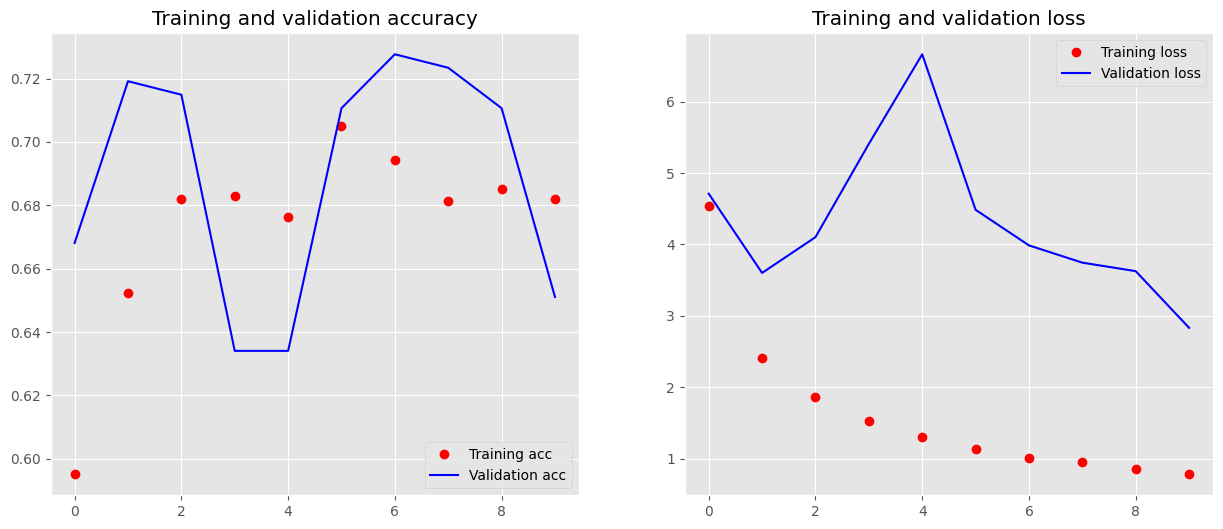

In [56]:
plot_training_history(history)

In [57]:
model.evaluate(train_generator)

101/101 [==============================] - 2s 17ms/step - loss: 0.7461 - accuracy: 0.6681


[0.7461354732513428, 0.6681168675422668]

In [58]:
model.evaluate(val_generator)

8/8 [==============================] - 1s 151ms/step - loss: 2.8318 - accuracy: 0.6511


[2.831819534301758, 0.651063859462738]

In [59]:
model.evaluate(test_generator)

8/8 [==============================] - 1s 171ms/step - loss: 2.9692 - accuracy: 0.6417


[2.9692275524139404, 0.6416666507720947]

# Exctracting Features

In [29]:
model = ResNet50(weights = 'imagenet', include_top=False)

94765736/94765736 [==============================] - 0s 0us/step


In [30]:
path = "/kaggle/working/output/val/benign"
benign_images_val = load_and_process_images(path, width, height)
path = "/kaggle/working/output/val/malignant"
malignant_images_val = load_and_process_images(path, width, height)
path = "/kaggle/working/output/val/normal"
normal_images_val = load_and_process_images(path, width, height)

In [31]:
path = "/kaggle/working/output/test/benign"
benign_images_test = load_and_process_images(path, width, height)
path = "/kaggle/working/output/test/malignant"
malignant_images_test = load_and_process_images(path, width, height)
path = "/kaggle/working/output/test/normal"
normal_images_test = load_and_process_images(path, width, height)

In [32]:
%%capture --no-display
# Training
normal_images_train = extract_features(normal_images)
benign_images_train = extract_features(benign_images)
malignant_images_train = extract_features(malignant_images)
# Validation
benign_images_val = extract_features(benign_images_val)
malignant_images_val = extract_features(malignant_images_val)
normal_images_val = extract_features(normal_images_val)
# Testing
benign_images_test = extract_features(benign_images_test)
malignant_images_test = extract_features(malignant_images_test)
normal_images_test = extract_features(normal_images_test)

In [33]:
# Training
normal_images_train = np.concatenate([normal_images_train,normal_images_val], axis = 0)
benign_images_train = np.concatenate([benign_images_train,benign_images_val], axis = 0)
malignant_images_train = np.concatenate([malignant_images_train,malignant_images_val], axis = 0)

In [34]:
# Normal Class --> 0
# Benign Class --> 1
# Malignant Class --> 2
X_train = np.concatenate([normal_images_train,benign_images_train,malignant_images_train], axis = 0)
y_train = np.concatenate([np.zeros((len(normal_images_train))), np.ones((len(benign_images_train))),
                         np.zeros((len(malignant_images_train))) + 2 ], axis = 0)

X_test = np.concatenate([normal_images_test,benign_images_test,malignant_images_test], axis = 0)
y_test = np.concatenate([np.zeros((len(normal_images_test))), np.ones((len(benign_images_test))),
                         np.zeros((len(malignant_images_test))) + 2 ], axis = 0)

In [35]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(3453, 32768) (3453,) (240, 32768) (240,)


# Dimensionality Reduction Using PCA

In [36]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [37]:
pca = PCA(n_components = 0.80)
X_train = pca.fit_transform(X_train)
print(X_test.shape)
X_test = pca.transform(X_test)
print(X_test.shape)

(240, 32768)
(240, 288)


# Classification Using RF

In [38]:
num_samples = X_train.shape[0]

shuffled_indices = np.random.permutation(num_samples)
X_train = X_train[shuffled_indices]
y_train = y_train[shuffled_indices]

In [39]:
num_samples = X_test.shape[0]

shuffled_indices = np.random.permutation(num_samples)
X_test = X_test[shuffled_indices]
y_test = y_test[shuffled_indices]

In [40]:
clf =  RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [41]:
Counter(y_train)

Counter({2.0: 1326, 0.0: 1103, 1.0: 1024})

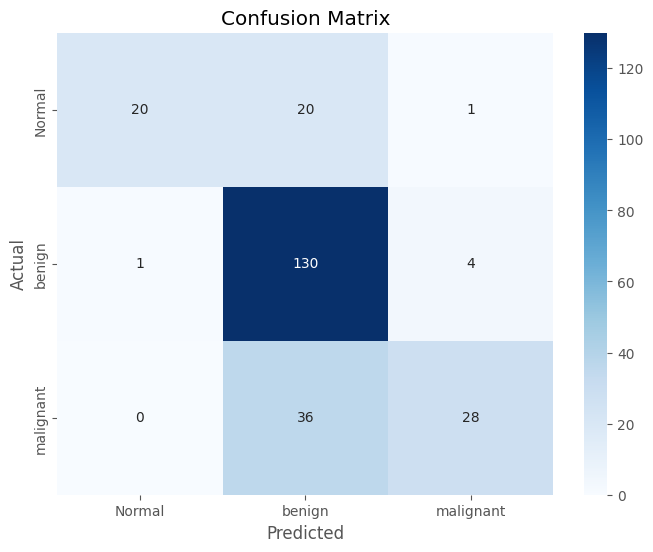

In [42]:
report = conf_matrix(clf, X_test, ['Normal', 'benign', 'malignant'], "ml", y_test)

In [43]:
print(report)

              precision    recall  f1-score   support

         0.0       0.95      0.49      0.65        41
         1.0       0.70      0.96      0.81       135
         2.0       0.85      0.44      0.58        64

    accuracy                           0.74       240
   macro avg       0.83      0.63      0.68       240
weighted avg       0.78      0.74      0.72       240



# Optimization Using Grid Search

In [49]:
param_grid = {
    'n_estimators': [5,10,30,50, 100],
    'max_depth': [None, 10, 20,25,30,40],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=clf, param_grid = param_grid, n_jobs=-1)

In [50]:
grid_search.fit(X_train, y_train)
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters found:  {'bootstrap': False, 'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation score: 0.83


In [51]:
best_rf = grid_search.best_estimator_
print(best_rf)

RandomForestClassifier(bootstrap=False, max_depth=25, min_samples_split=5)


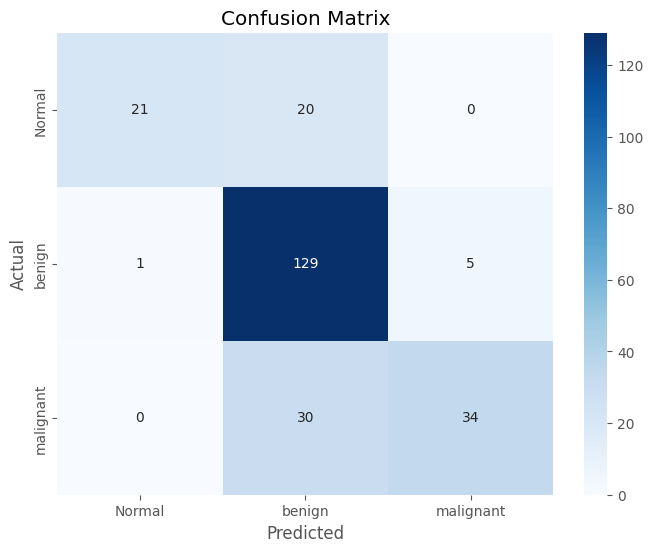

In [52]:
report = conf_matrix(best_rf, X_test, ['Normal', 'benign', 'malignant'], "ml", y_test)

In [53]:
print(report)

              precision    recall  f1-score   support

         0.0       0.95      0.51      0.67        41
         1.0       0.72      0.96      0.82       135
         2.0       0.87      0.53      0.66        64

    accuracy                           0.77       240
   macro avg       0.85      0.67      0.72       240
weighted avg       0.80      0.77      0.75       240

